In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

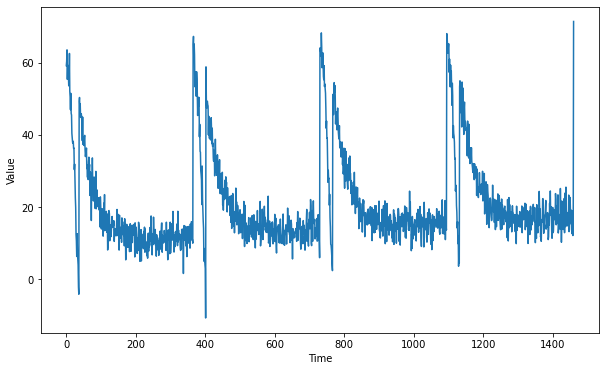

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


In [39]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[G.WINDOW_SIZE]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),        
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    
    ### END CODE HERE

    return model

In [40]:
dataset

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

In [41]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


In [42]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [43]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 9s 279ms/step - loss: 39.7264 - mae: 40.2435
Epoch 2/100
34/34 [==============================] - 1s 41ms/step - loss: 33.9687 - mae: 34.4538
Epoch 3/100
34/34 [==============================] - 1s 41ms/step - loss: 27.4431 - mae: 27.9677
Epoch 4/100
34/34 [==============================] - 1s 42ms/step - loss: 20.2093 - mae: 20.7282
Epoch 5/100
34/34 [==============================] - 1s 42ms/step - loss: 13.0111 - mae: 13.5041
Epoch 6/100
34/34 [==============================] - 2s 50ms/step - loss: 10.3411 - mae: 10.8230
Epoch 7/100
34/34 [==============================] - 2s 57ms/step - loss: 9.8526 - mae: 10.3320
Epoch 8/100
34/34 [==============================] - 2s 52ms/step - loss: 9.3437 - mae: 9.8111
Epoch 9/100
34/34 [==============================] - 2s 50ms/step - loss: 8.7863 - mae: 9.2767
Epoch 10/100
34/34 [==============================] - 2s 59ms/step - loss: 8.2204 - mae: 8.7019
Epoch 11/100
34/34 [===============

34/34 [==============================] - 1s 41ms/step - loss: 2.8327 - mae: 3.3015
Epoch 87/100
34/34 [==============================] - 1s 40ms/step - loss: 2.7575 - mae: 3.2279
Epoch 88/100
34/34 [==============================] - 1s 42ms/step - loss: 2.9868 - mae: 3.4524
Epoch 89/100
34/34 [==============================] - 2s 61ms/step - loss: 2.8640 - mae: 3.3335
Epoch 90/100
34/34 [==============================] - 1s 44ms/step - loss: 2.4928 - mae: 2.9614
Epoch 91/100
34/34 [==============================] - 2s 48ms/step - loss: 2.7443 - mae: 3.1797
Epoch 92/100
34/34 [==============================] - 2s 49ms/step - loss: 2.7726 - mae: 3.2421
Epoch 93/100
34/34 [==============================] - 2s 61ms/step - loss: 2.8594 - mae: 3.3267
Epoch 94/100
34/34 [==============================] - 2s 61ms/step - loss: 2.8939 - mae: 3.3410
Epoch 95/100
34/34 [==============================] - 2s 73ms/step - loss: 2.9195 - mae: 3.3848
Epoch 96/100
34/34 [==============================] -

(1e-06, 1.0, 0.0, 30.0)

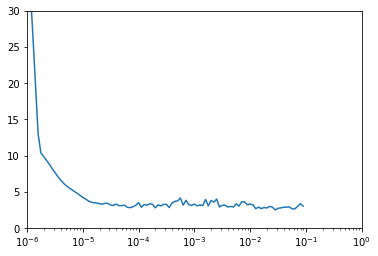

In [44]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

In [45]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [46]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=100)

Epoch 1/100
34/34 [==============================] - 6s 180ms/step - loss: 7.0012 - mae: 7.4906
Epoch 2/100
34/34 [==============================] - 1s 40ms/step - loss: 3.2303 - mae: 3.7006
Epoch 3/100
34/34 [==============================] - 1s 41ms/step - loss: 2.9752 - mae: 3.4401
Epoch 4/100
34/34 [==============================] - 1s 41ms/step - loss: 3.3102 - mae: 3.7616
Epoch 5/100
34/34 [==============================] - 1s 41ms/step - loss: 3.2233 - mae: 3.6808
Epoch 6/100
34/34 [==============================] - 1s 41ms/step - loss: 3.1203 - mae: 3.5913
Epoch 7/100
34/34 [==============================] - 1s 40ms/step - loss: 2.9120 - mae: 3.3653
Epoch 8/100
34/34 [==============================] - 1s 43ms/step - loss: 3.4445 - mae: 3.9154
Epoch 9/100
34/34 [==============================] - 2s 49ms/step - loss: 2.9045 - mae: 3.3745
Epoch 10/100
34/34 [==============================] - 2s 46ms/step - loss: 2.9170 - mae: 3.3782
Epoch 11/100
34/34 [============================

34/34 [==============================] - 1s 42ms/step - loss: 2.4516 - mae: 2.9126
Epoch 87/100
34/34 [==============================] - 1s 41ms/step - loss: 2.4080 - mae: 2.8604
Epoch 88/100
34/34 [==============================] - 1s 40ms/step - loss: 2.6092 - mae: 3.0747
Epoch 89/100
34/34 [==============================] - 1s 40ms/step - loss: 2.4206 - mae: 2.8842
Epoch 90/100
34/34 [==============================] - 1s 40ms/step - loss: 2.4622 - mae: 2.9232
Epoch 91/100
34/34 [==============================] - 1s 40ms/step - loss: 2.4961 - mae: 2.9563
Epoch 92/100
34/34 [==============================] - 1s 40ms/step - loss: 2.5010 - mae: 2.9658
Epoch 93/100
34/34 [==============================] - 1s 40ms/step - loss: 2.6270 - mae: 3.0951
Epoch 94/100
34/34 [==============================] - 1s 44ms/step - loss: 2.4077 - mae: 2.8621
Epoch 95/100
34/34 [==============================] - 1s 43ms/step - loss: 2.6435 - mae: 3.1134
Epoch 96/100
34/34 [==============================] -

In [47]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [48]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


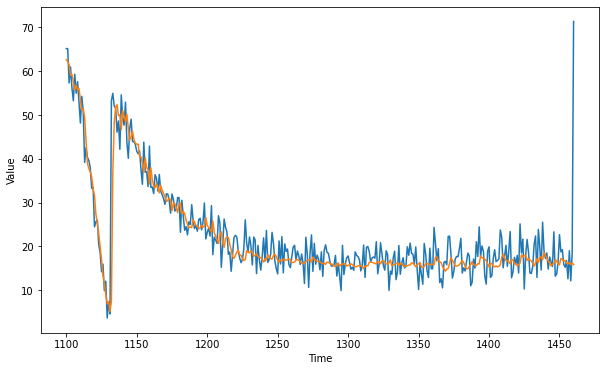

In [49]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [50]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 26.98, mae: 3.05 for forecast
